# House Pricing - Linear Regression

In [97]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.formula.api as sm
import scipy.stats as stats
import pandas_profiling   #need to install using anaconda prompt (pip install pandas_profiling)

%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 7.5
plt.rcParams['axes.grid'] = True
plt.gray()

from matplotlib.backends.backend_pdf import PdfPages

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

<Figure size 720x540 with 0 Axes>

## Pre Modelling

In [98]:
data = pd.read_csv('House_Prices.csv')

In [99]:
data.head(2)

,Home,Price,SqFt,Bedrooms,Bathrooms,Offers,Brick,Neighborhood
0,1,114300,1790,2,2,2,No,East
1,2,114200,2030,4,2,3,No,East


In [100]:
data.shape

(128, 8)

Duplicate Rows Check

In [101]:
data.duplicated().value_counts()

False    128
dtype: int64

In [102]:
data.dtypes

Home             int64
Price            int64
SqFt             int64
Bedrooms         int64
Bathrooms        int64
Offers           int64
Brick           object
Neighborhood    object
dtype: object

In [103]:
#pandas_profiling.ProfileReport(data)   

## Modelling

### Data Preparation I

Converting the Data types

In [104]:
data.dtypes

Home             int64
Price            int64
SqFt             int64
Bedrooms         int64
Bathrooms        int64
Offers           int64
Brick           object
Neighborhood    object
dtype: object

In [105]:
Column_dtype = dict(data.dtypes)

Num_Columns=[key for key in Column_dtype if Column_dtype[key] in ['float64', 'int64', 'float32', 'int32']]
Cat_Columns=[key for key in Column_dtype if Column_dtype[key] in ['object']]


In [106]:
Num_Columns = ['Home', 'Price', 'SqFt', 'Bedrooms', 'Bathrooms']

In [107]:
Cat_Columns.append('Offers')

In [108]:
data_num = data[Num_Columns]

In [109]:
data_cat = data[Cat_Columns]

In [110]:
def outlier_miss_treat(x):
    x = x.clip_upper(x.quantile(0.99))
    x = x.clip_lower(x.quantile(0.01))
    x = x.fillna(x.median())
    return x

data_num = data_num.apply(outlier_miss_treat)

In [111]:
data_num.head(2)

,Home,Price,SqFt,Bedrooms,Bathrooms
0,2.27,114300,1790.0,2.0,2
1,2.27,114200,2030.0,4.0,2


In [112]:
def miss_treat_cat(x):
    x = x.fillna(x.mode())
    return x

data_cat = data_cat.apply(miss_treat_cat)

In [113]:
data_cat.head(2)

,Brick,Neighborhood,Offers
0,No,East,2
1,No,East,3


In [114]:
data_cat.Offers = data_cat.Offers.astype('object')

In [115]:
data_cat_dummy = pd.get_dummies(data_cat, drop_first=True);

In [116]:
data_cat_dummy.head(2)

,Brick_Yes,Neighborhood_North,Neighborhood_West,Offers_2,Offers_3,Offers_4,Offers_5,Offers_6
0,0,0,0,1,0,0,0,0
1,0,0,0,0,1,0,0,0


In [117]:
# Concate the Categorical and Numerical Columns
data = pd.concat([data_num, data_cat_dummy], axis=1)

In [118]:
data.head()

,Home,Price,SqFt,Bedrooms,Bathrooms,Brick_Yes,Neighborhood_North,Neighborhood_West,Offers_2,Offers_3,Offers_4,Offers_5,Offers_6
0,2.27,114300,1790.0,2.0,2,0,0,0,1,0,0,0,0
1,2.27,114200,2030.0,4.0,2,0,0,0,0,1,0,0,0
2,3.00,114800,1740.0,3.0,2,0,0,0,0,0,0,0,0
3,4.00,94700,1980.0,3.0,2,0,0,0,0,1,0,0,0
4,5.00,119800,2130.0,3.0,3,0,0,0,0,1,0,0,0


## Data Preparation II

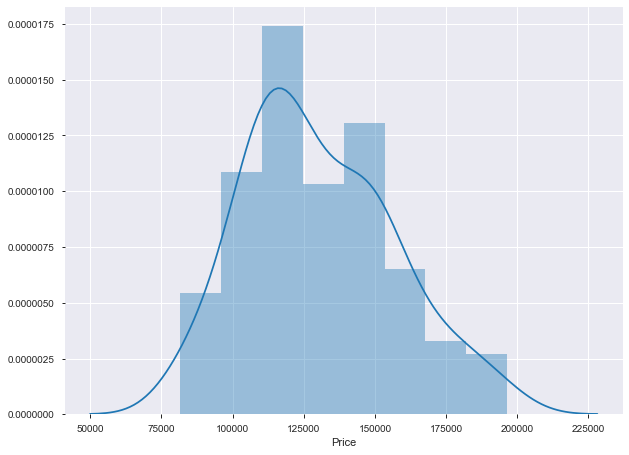

In [119]:
sns.distplot(data.Price)

In [120]:
data.Price.skew()

0.4375546058453628

In [121]:
data.Price.kurtosis()

-0.3439301947932223

Feature Transformation of Price into Normal Distribution

In [122]:
data['ln_Price'] = np.log(data.Price)

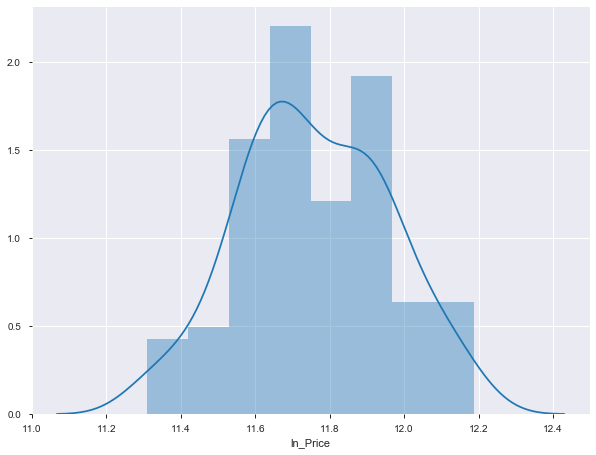

In [123]:
sns.distplot(data.ln_Price)

In [124]:
data.ln_Price.skew()

-8.950777513011805e-05

In [125]:
data.ln_Price.kurtosis()

-0.4867558964442198

Correlation of Y with X

In [126]:
data_x = data[data.columns.difference(['Price','ln_Price'])]
data_x.head(2)

,Bathrooms,Bedrooms,Brick_Yes,Home,Neighborhood_North,Neighborhood_West,Offers_2,Offers_3,Offers_4,Offers_5,Offers_6,SqFt
0,2,2.0,0,2.27,0,0,1,0,0,0,0,1790.0
1,2,4.0,0,2.27,0,0,0,1,0,0,0,2030.0


In [127]:
data_y = data[['Price','ln_Price']]
data_y.head(2)

,Price,ln_Price
0,114300,11.646582
1,114200,11.645707


In [128]:
data_x.corrwith(data_y.ln_Price)

Bathrooms             0.493268
Bedrooms              0.506316
Brick_Yes             0.443745
Home                  0.104305
Neighborhood_North   -0.562398
Neighborhood_West     0.697178
Offers_2              0.077166
Offers_3             -0.117553
Offers_4             -0.156272
Offers_5             -0.067975
Offers_6             -0.154112
SqFt                  0.553127
dtype: float64

In [129]:
data_x.corrwith(data_y.Price)

Bathrooms             0.501744
Bedrooms              0.523483
Brick_Yes             0.452717
Home                  0.100964
Neighborhood_North   -0.551407
Neighborhood_West     0.719472
Offers_2              0.059093
Offers_3             -0.106946
Offers_4             -0.148558
Offers_5             -0.076075
Offers_6             -0.135889
SqFt                  0.549070
dtype: float64

Corr b/w Xs

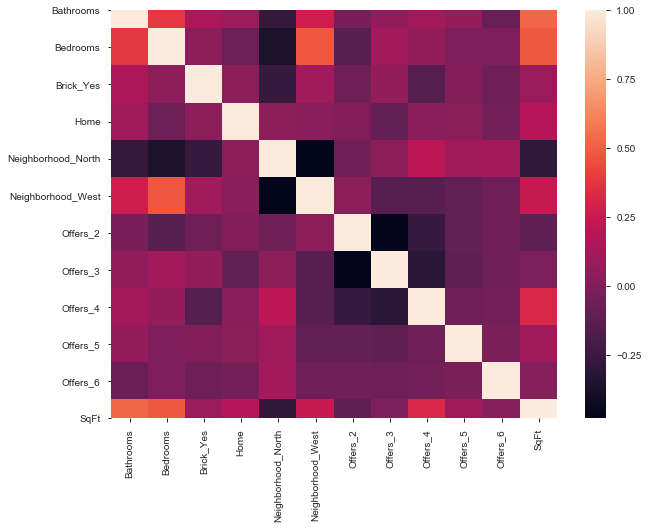

In [130]:
corr_matrix = data_x.corr()
#corr_matrix.to_csv('corrm.csv')

# visualize correlation matrix in Seaborn using a heatmap
sns.heatmap(data_x.corr())

In [131]:
pandas_profiling.ProfileReport(data);

Heteroscedascity

In [132]:
Y = data.ln_Price

In [133]:
np.var(Y)

0.04001317358840856

In [134]:
np.var(Y[:len(Y)//2])

0.04047267688275677

In [135]:
np.var(Y[len(Y)//2:])

0.038070950711324485

## Data Preparation III (Feature Reduction)

In [136]:
data_x.apply(np.var)

Bathrooms                 0.246094
Bedrooms                  0.507332
Brick_Yes                 0.220459
Home                   1362.228841
Neighborhood_North        0.225586
Neighborhood_West         0.211853
Offers_2                  0.202148
Offers_3                  0.230225
Offers_4                  0.126404
Offers_5                  0.022888
Offers_6                  0.007751
SqFt                  42771.713884
dtype: float64

Correlation X and Y

In [137]:
abs(data_x.corrwith(data_y.ln_Price)).sort_values(ascending=False)                  #####1

Neighborhood_West     0.697178
Neighborhood_North    0.562398
SqFt                  0.553127
Bedrooms              0.506316
Bathrooms             0.493268
Brick_Yes             0.443745
Offers_4              0.156272
Offers_6              0.154112
Offers_3              0.117553
Home                  0.104305
Offers_2              0.077166
Offers_5              0.067975
dtype: float64

RFE

In [138]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

In [139]:
lm = LinearRegression()

In [140]:
rfe = RFE(lm, n_features_to_select=6)
rfe = rfe.fit(data_x, Y)

In [141]:
data_x.shape

(128, 12)

In [142]:
data_x.columns[rfe.get_support()]                                                   #####2

Index(['Bathrooms', 'Brick_Yes', 'Neighborhood_West', 'Offers_4', 'Offers_5',
       'Offers_6'],
      dtype='object')

F-regression (Univariate)

In [143]:
from sklearn.feature_selection import f_regression
F_values, p_values  = f_regression(data_x, Y ) 

In [144]:
F_values = pd.Series(F_values)
p_values = pd.Series(p_values)
cols = pd.Series(data_x.columns)

f_vars = pd.concat([cols,F_values,p_values],axis=1)
f_vars.columns = ['col','f_val','p_val']

In [145]:
f_vars = f_vars.sort_values(by=['f_val'],ascending=False)
f_vars.col.head(6)                                                              #####3

5      Neighborhood_West
4     Neighborhood_North
11                  SqFt
1               Bedrooms
0              Bathrooms
2              Brick_Yes
Name: col, dtype: object

Select K-best

In [146]:
from sklearn.feature_selection import SelectKBest, f_classif, chi2 
selector = SelectKBest(f_classif, k=6) # similarly can do for Chi square
selector.fit(data_x, Y)

SelectKBest(k=6, score_func=<function f_classif at 0x000000000E0ECD38>)

In [147]:
data_x.columns[selector.get_support()]                                         ####4

Index(['Brick_Yes', 'Neighborhood_West', 'Offers_2', 'Offers_4', 'Offers_6',
       'SqFt'],
      dtype='object')

VIF

In [148]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

VIF = [variance_inflation_factor(data_x.values,i) for i in range(data_x.shape[1])]

In [149]:
VIF_results = pd.concat([pd.Series(data_x.columns), pd.Series(VIF)],axis=1)
VIF_results.columns = ['Feature','VIF']
VIF_results = VIF_results.sort_values('VIF',ascending=False) 

# Some vars with High VIF value might also have a good correlation with Y. So it can't be eliminated
VIF_results2 = VIF_results.sort_values('VIF',ascending=True)

In [150]:
VIF_results2.head(6)

,Feature,VIF
10,Offers_6,1.115709
9,Offers_5,1.280580
2,Brick_Yes,1.686783
4,Neighborhood_North,2.131486
5,Neighborhood_West,2.519433
8,Offers_4,2.614337


In [151]:
features = {'Neighborhood_West',
'Neighborhood_North',
'SqFt',
'Bedrooms',
'Bathrooms',
'Brick_Yes',
'Neighborhood_West',
'Neighborhood_North',
'SqFt',
'Bedrooms',
'Bathrooms',
'Brick_Yes',
'Offers_6',
'Offers_5',
'Brick_Yes',
'Neighborhood_North',
'Neighborhood_West',
'Offers_4',
'Bathrooms', 'Brick_Yes', 'Neighborhood_West', 'Offers_4', 'Offers_5','Offers_6',
'Brick_Yes', 'Neighborhood_West', 'Offers_2', 'Offers_4', 'Offers_6','SqFt'}


In [152]:
x = list(features)

In [153]:
x

['Offers_6',
 'Brick_Yes',
 'Bedrooms',
 'Neighborhood_North',
 'Neighborhood_West',
 'Offers_5',
 'Offers_4',
 'Offers_2',
 'Bathrooms',
 'SqFt']

In [154]:
d_x = data_x[x]

In [155]:
d_x

,Offers_6,Brick_Yes,Bedrooms,Neighborhood_North,Neighborhood_West,Offers_5,Offers_4,Offers_2,Bathrooms,SqFt
0,0,0,2.0,0,0,0,0,1,2,1790.0
1,0,0,4.0,0,0,0,0,0,2,2030.0
2,0,0,3.0,0,0,0,0,0,2,1740.0
3,0,0,3.0,0,0,0,0,0,2,1980.0
4,0,0,3.0,0,0,0,0,0,3,2130.0
...,...,...,...,...,...,...,...,...,...,...
123,0,1,3.0,0,0,0,0,0,3,1900.0
124,0,1,4.0,0,0,0,0,0,3,2160.0
125,0,0,2.0,1,0,0,0,1,2,2070.0
126,0,0,3.0,0,1,0,0,0,3,2020.0


## Data Preparation IV

In [156]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(d_x, data_y, test_size = 0.3, random_state = 123)

In [157]:
X_test.shape , X_train.shape

((39, 10), (89, 10))

In [158]:
y_test.shape , y_train.shape

((39, 2), (89, 2))

## Model Implementation

In [159]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train.ln_Price)

# Predicting the Test set results
y_pred = regressor.predict(X_test)

In [160]:
pd.concat([pd.Series(y_pred),y_test.ln_Price.reset_index()],axis=1).head()

,0,index,ln_Price
0,11.746741,4,11.693579
1,11.793199,123,11.692744
2,11.854910,90,11.871299
3,11.987041,82,12.012488
4,11.625773,42,11.567414


In [161]:
res = pd.concat([pd.Series(y_pred),y_test.ln_Price.reset_index()],axis=1)

In [162]:
res = res.iloc[:,[0,2]]

In [163]:
res.columns = ['y_pred','y']

In [164]:
res.head()

,y_pred,y
0,11.746741,11.693579
1,11.793199,11.692744
2,11.854910,11.871299
3,11.987041,12.012488
4,11.625773,11.567414


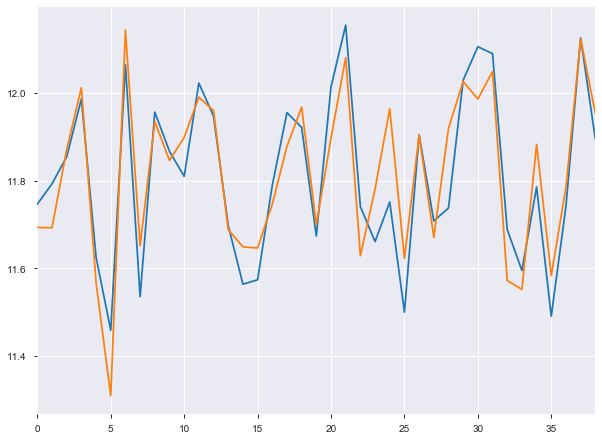

In [165]:
res.iloc[:,0].plot()
res.iloc[:,1].plot()

In [166]:
res1 = res.copy()

In [167]:
res1['y_pred'] = np.exp(res.y_pred)
res1['y'] = np.exp(res.y)

In [168]:
res.head(2)

,y_pred,y
0,11.746741,11.693579
1,11.793199,11.692744


In [169]:
res1.head()

,y_pred,y
0,126341.082383,119800.0
1,132349.216182,119700.0
2,140773.820966,143100.0
3,160659.210761,164800.0
4,111946.174235,105600.0


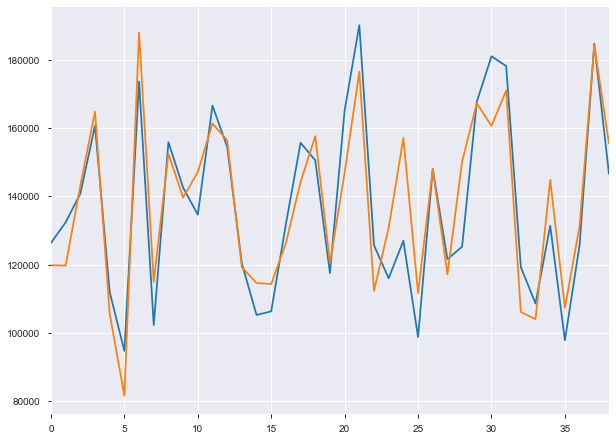

In [170]:
res1.y_pred.plot()
res1.y.plot()

## Model Evaluation

MAPE

In [171]:
y_pred_t = regressor.predict(X_train)

In [172]:
# Mean Absolute Percentage Error
MAPE_train = np.mean(np.abs(y_train.ln_Price - y_pred_t)/y_train.ln_Price )
MAPE_test = np.mean(np.abs(y_test.ln_Price - y_pred)/y_test.ln_Price )

In [173]:
MAPE_train, MAPE_test

(0.005597961755509397, 0.005939092516744373)

RMSE

In [174]:
RMSE_train = metrics.mean_squared_error(y_train.ln_Price , y_pred_t)
RMSE_test = metrics.mean_squared_error(y_test.ln_Price , y_pred)

In [175]:
RMSE_test,RMSE_train

(0.007389538221037877, 0.007054507611485263)

Corr b/w Y and Y^

In [176]:
Corr_train = stats.stats.pearsonr(y_train.ln_Price , y_pred_t)
Corr_test = stats.stats.pearsonr(y_test.ln_Price,y_pred)

In [177]:
Corr_test,Corr_train

((0.8966454788217729, 1.1680123586712153e-14),
 (0.9078892706362027, 1.3286866004469922e-34))

Decile Analysis

In [178]:
X_train.shape , y_pred_t.shape,y_train.ln_Price.shape

((89, 10), (89,), (89,))

In [179]:
train = pd.concat([X_train.reset_index(drop=True),pd.Series(y_pred_t),y_train.ln_Price.reset_index(drop=True)],axis=1)

In [180]:
train.head(2)

,Offers_6,Brick_Yes,Bedrooms,Neighborhood_North,Neighborhood_West,Offers_5,Offers_4,Offers_2,Bathrooms,SqFt,0,ln_Price
0,0,0,4.0,0,1,0,0,0,2,1780.0,11.777967,11.874787
1,0,0,3.0,0,0,0,1,0,2,1910.0,11.516059,11.318126


In [181]:
train.columns = ['Bathrooms','Offers_4','SqFt',
                 'Bedrooms','Offers_6', 'Neighborhood_North',
                 'Offers_2','Offers_5','Brick_Yes','Neighborhood_West', 'pred_Price', 'ln_Price']

In [182]:
train['Deciles']=pd.qcut(train['ln_Price'],10, labels=False)

avg_Y = train[['Deciles', 'ln_Price']].groupby(train.Deciles).mean().sort_index(ascending=False)['ln_Price']

avg_pred_Y = train[['Deciles','pred_Price']].groupby(train.Deciles).mean().sort_index(ascending=False)['pred_Price']

# Decile for test

# similarly find the avg_Y, avg_pred_Y for the test

# Compare the Deciles values of the Y and pred_Y for train and test separately.

# Plot them in Multi-line graph and Compare the patterns in Test graph and Train graph.

In [183]:
pd.concat([avg_pred_Y,avg_Y],axis=1)

,pred_Price,ln_Price
Deciles,,
9,12.081659,12.103053
8,11.874231,11.937312
7,11.855493,11.876285
6,11.828967,11.805942
5,11.718830,11.749907
4,11.684800,11.693608
3,11.638054,11.649694
2,11.578516,11.595542
1,11.554833,11.532279


Decile Analysis (test)

In [184]:
X_test.shape , y_pred.shape,y_test.ln_Price.shape

((39, 10), (39,), (39,))

In [185]:
test = pd.concat([X_test.reset_index(drop=True),pd.Series(y_pred),y_test.ln_Price.reset_index(drop=True)],axis=1)

In [186]:
test.head(2)

,Offers_6,Brick_Yes,Bedrooms,Neighborhood_North,Neighborhood_West,Offers_5,Offers_4,Offers_2,Bathrooms,SqFt,0,ln_Price
0,0,0,3.0,0,0,0,0,0,3,2130.0,11.746741,11.693579
1,0,1,3.0,0,0,0,0,0,3,1900.0,11.793199,11.692744


In [187]:
test.columns = ['Bathrooms','Offers_4','SqFt',
                 'Bedrooms','Offers_6', 'Neighborhood_North',
                 'Offers_2','Offers_5','Brick_Yes','Neighborhood_West', 'pred_Price', 'ln_Price']

In [188]:
test['Deciles']=pd.qcut(test['ln_Price'],10, labels=False)

avg_Y = test[['Deciles', 'ln_Price']].groupby(test.Deciles).mean().sort_index(ascending=False)['ln_Price']

avg_pred_Y = test[['Deciles','pred_Price']].groupby(test.Deciles).mean().sort_index(ascending=False)['pred_Price']

# Decile for test

# similarly find the avg_Y, avg_pred_Y for the test

# Compare the Deciles values of the Y and pred_Y for train and test separately.

# Plot them in Multi-line graph and Compare the patterns in Test graph and Train graph.

In [189]:
pd.concat([avg_pred_Y,avg_Y],axis=1)

,pred_Price,ln_Price
Deciles,,
9,12.109161,12.099753
8,12.036521,12.004282
7,11.879190,11.961596
6,11.852480,11.914451
5,11.918640,11.886524
4,11.781355,11.821125
3,11.750833,11.708036
2,11.626423,11.665091
1,11.576517,11.620393


Residual Analysis

In [190]:
model.resid.hist(bins=100)  # Where "model" stats model 
                            # does not work with sklearn

NameError: name 'model' is not defined

In [ ]:
test.head(2)

In [ ]:
np.exp(11.74)

In [ ]:
regressor

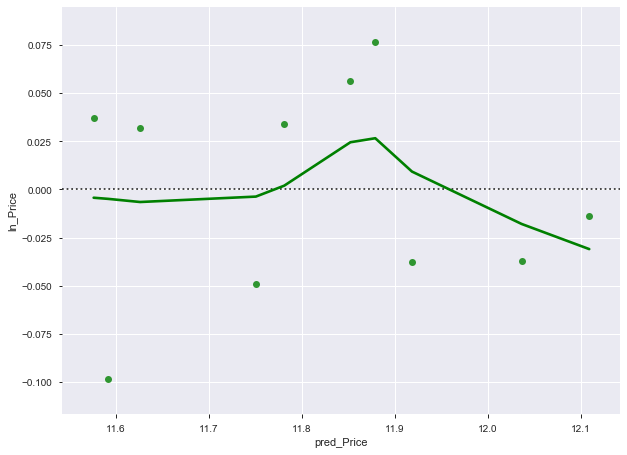

In [191]:
sns.residplot(avg_pred_Y, avg_Y, lowess=True, color="g")

Text(0, 0.5, 'Residual')

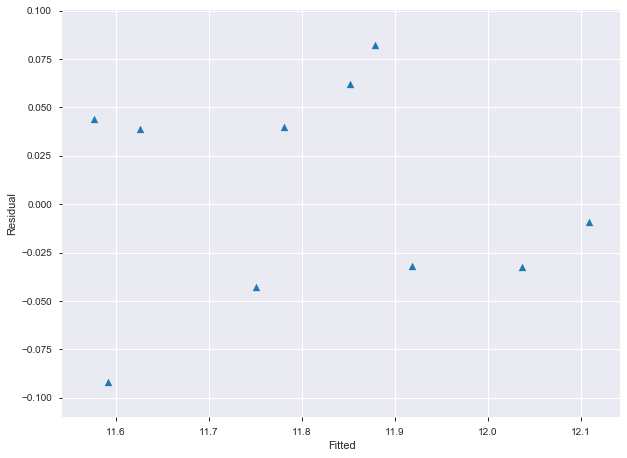

In [192]:
plt.scatter(avg_pred_Y,(avg_Y-avg_pred_Y),marker='^')
plt.xlabel("Fitted")
plt.ylabel("Residual")

(array([1., 0., 0., 0., 0., 1., 2., 0., 0., 1., 0., 0., 0., 0., 1., 2., 0.,
        1., 0., 1.]),
 array([-0.09187329, -0.08315934, -0.0744454 , -0.06573145, -0.05701751,
        -0.04830357, -0.03958962, -0.03087568, -0.02216173, -0.01344779,
        -0.00473384,  0.0039801 ,  0.01269405,  0.02140799,  0.03012194,
         0.03883588,  0.04754982,  0.05626377,  0.06497771,  0.07369166,
         0.0824056 ]),
 <a list of 20 Patch objects>)

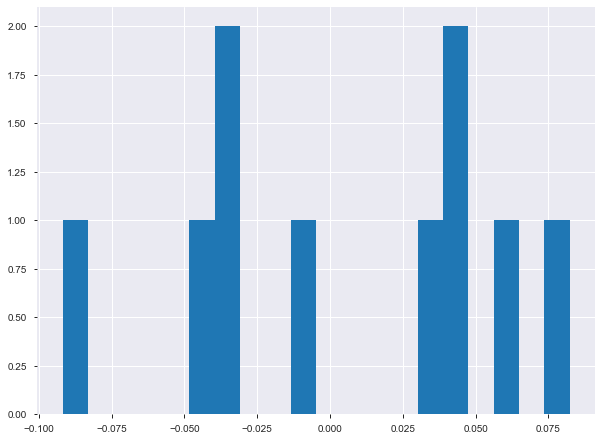

In [203]:
plt.hist((avg_Y-avg_pred_Y),bins=20)

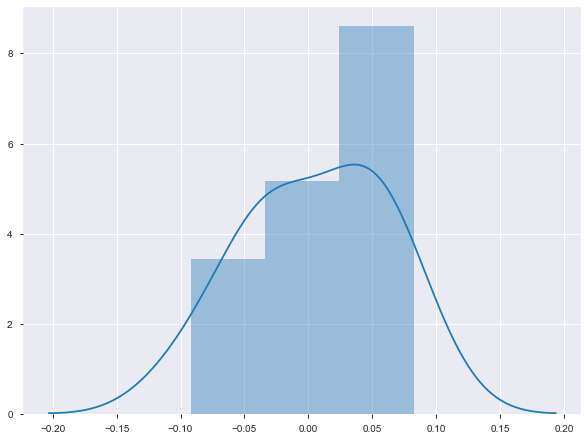

In [205]:
sns.distplot((avg_Y-avg_pred_Y))

In [206]:
(avg_Y-avg_pred_Y).skew()

-0.32906296657050926

In [208]:
(avg_Y-avg_pred_Y).kurtosis()

-0.8932032085225301